<a href="https://colab.research.google.com/github/truongnc160466/main1/blob/main/VietnameseStreetFoodUpdated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle


!pip install numba
''' !find / -iname 'libdevice'
!find / -iname 'libnvvm.so'
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so" '''
from numba import njit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Import

Dataset: annotation-sheet.csv                              
[Dataset Github Link](https://github.com/truongnc160466/main1/blob/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv)                   
[RAW Dataset Link](https://raw.githubusercontent.com/truongnc160466/main1/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv)

1 - Data Retrieve

In [2]:
# Raw dataset link 
url = 'https://raw.githubusercontent.com/truongnc160466/main1/4b453c52860c1a40065d7974bb177d32b46ff74c/annotation_sheet.csv'
df = pd.read_csv(url)

# Shuffle data (we will shuffle the data later in the model anyway)
df = df.sample(frac = 1).reset_index(drop = True)

df.head()

,no,video_index,student_id,student_name,video_id,standardized_dish,dish_occurence,dish_imply,duration,start_time,...,standardized_sauce,sauce,venue,container,recipes,viewer_feeling,food_feeling,youtuber_feeling,location,foreigner
0,3427,962,SE150102,Hoàng Thanh Hải,iljkdsw4JfA,pigeon fried rice,pigeon fried rice,cơm chiên bồ câu,100,03:00,...,peanut salt,peanut salt,fine,hands_on,0,4,5,5,Hà Nội,1
1,3605,1004,SE160968,Nguyễn Hoàng Việt,Y6TRwhPSYz4,wonton soup,one ton soup,súp hoành thánh,63,05:34,...,NaN,NaN,street,bowl,0,5,4,5,Ho Chi Minh,1
2,1945,546,SE160939,Dương Trung Hiếu,v06jVwUoDU4,Dumpling,NaN,Há Cảo,31,00:53,...,NaN,Nước Mắm,casual,plate,0,4,2,2,QuangNam,1
3,2848,795,SE160761,Nguyễn Đình Hùng Sơn,umi1XSZAgug,Seafood spring roll,Seafood spring roll,Bánh tráng cuốn hải sản,66,03:46,...,fish sauce,fish sauce,casual,hands_on,1,4,4,4,Nha Trang,1
4,1487,382,SE161434,Võ Thành Nam,9mZVp_MAbpI,Crab Paste Vermicelli Soup,NaN,bún riêu,40,04:28,...,NaN,shrimp sauce,street,bowl,0,4,4,3,Sài Gòn,1


2 - Data Description

In [3]:
print('Dataframe info: ')
df.info()
print('\n\n')
print('Dataframe description: ')
df.describe().transpose()

Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   no                              3757 non-null   int64 
 1   video_index                     3757 non-null   int64 
 2   student_id                      2884 non-null   object
 3   student_name                    2884 non-null   object
 4   video_id                        3757 non-null   object
 5   standardized_dish               3757 non-null   object
 6   dish_occurence                  3313 non-null   object
 7   dish_imply                      3159 non-null   object
 8   duration                        3757 non-null   int64 
 9   start_time                      3757 non-null   object
 10  end_time                        3757 non-null   object
 11  standardized_ingredient         3119 non-null   object
 12  no_ingredient                  

,count,mean,std,min,25%,50%,75%,max
no,3757.0,1879.000000,1084.696809,1.0,940.0,1879.0,2818.0,3757.0
video_index,3757.0,515.537131,315.761411,1.0,234.0,527.0,786.0,1068.0
duration,3757.0,110.310088,921.869713,0.0,26.0,60.0,118.0,55958.0
no_ingredient,3757.0,3.284802,2.806564,0.0,1.0,3.0,5.0,20.0
recipes,3757.0,0.274421,0.446281,0.0,0.0,0.0,1.0,1.0
viewer_feeling,3757.0,3.740484,0.925898,1.0,3.0,4.0,4.0,5.0
food_feeling,3757.0,3.412563,1.172153,1.0,2.0,4.0,4.0,5.0
youtuber_feeling,3757.0,4.195369,0.860721,1.0,4.0,4.0,5.0,5.0
foreigner,3757.0,0.933191,0.249724,0.0,1.0,1.0,1.0,1.0


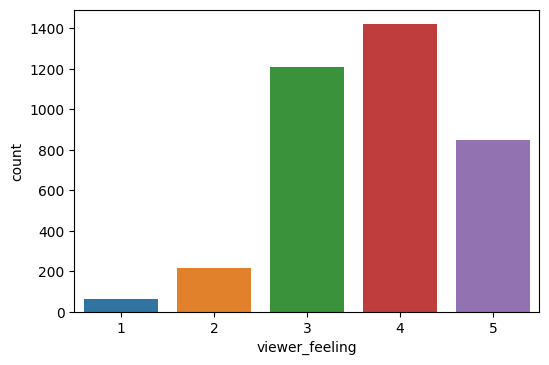

In [4]:
plt.figure(dpi = 100)
ax = sns.countplot(data = df, x = 'viewer_feeling')
plt.show()

# Data Preprocessing

1 - One Hot Encoding (Columns = venue, container)

In [5]:
label_df = pd.get_dummies(df[['container', 'venue']], prefix = {'container', 'venue'})

2 - Data Scaling (Columns = duration, no_ingredient)

In [6]:
df[["duration"]] = MinMaxScaler().fit_transform(df[["duration"]])
df[["no_ingredient"]] = MinMaxScaler().fit_transform(df[["no_ingredient"]])

3 - Define Features (X) And Data Values (Y)

In [7]:
input = np.array(df[['duration', 'no_ingredient', 'recipes']].join(label_df))
output = np.array(df[['viewer_feeling']])

# output = pd.get_dummies(df['viewer_feeling'], prefix = 'viewer_feeling')
# print(output)

input_train, input_test, output_train, output_test = train_test_split(input, output, test_size = 0.2, stratify = output)

print(input.shape, output.shape)

(3757, 17) (3757, 1)


4 - Oversampling (to handle the class imbalance)

In [8]:
output_train_tmp = pd.DataFrame(output_train)
output_train_tmp.value_counts().sort_values()

1      50
2     171
5     679
3     968
4    1137
dtype: int64

In [9]:
sm = SMOTE()
input_train_res, output_train_res = sm.fit_resample(input_train, output_train) 
counter = Counter(output_train_res)
print(counter)

Counter({4: 1137, 3: 1137, 5: 1137, 2: 1137, 1: 1137})


In [10]:
output_train_res_tmp = pd.DataFrame(output_train_res)
output_train_res_tmp.value_counts()

1    1137
2    1137
3    1137
4    1137
5    1137
dtype: int64

In [11]:
df[['duration', 'no_ingredient', 'recipes']].join(label_df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            3757 non-null   float64
 1   no_ingredient       3757 non-null   float64
 2   recipes             3757 non-null   int64  
 3   container_bag       3757 non-null   uint8  
 4   container_bottle    3757 non-null   uint8  
 5   container_bowl      3757 non-null   uint8  
 6   container_box       3757 non-null   uint8  
 7   container_glass     3757 non-null   uint8  
 8   container_hands_on  3757 non-null   uint8  
 9   container_other     3757 non-null   uint8  
 10  container_plate     3757 non-null   uint8  
 11  container_pot       3757 non-null   uint8  
 12  container_tray      3757 non-null   uint8  
 13  venue_casual        3757 non-null   uint8  
 14  venue_fine          3757 non-null   uint8  
 15  venue_other         3757 non-null   uint8  
 16  venue_

# New Model Building (NEO Model)

1 - Function Definitions

In [12]:
# SeLU Function
def selu(x):
    scale = float(1.0507009873554804934193349852946)
    alpha = float(1.6732632423543772848170429916717)
    return np.where(x > 0, scale * x, scale * alpha * (np.exp(x) - 1))

def selu_deri(x):
    scale = float(1.0507009873554804934193349852946)
    alpha = float(1.6732632423543772848170429916717)
    return np.where(x > 0, scale, scale * alpha * np.exp(x))

# ReLU Function
@njit(cache = True, fastmath = True)
def relu(x):
    # Broadcasting seems expensive compared to TF and PyTorch
    # return np.maximum(0., x)
    a = np.zeros(x.shape, dtype = np.float32)
    return np.maximum(a, x)
@njit(cache = True, fastmath = True)
def relu_deri(x):
    return np.greater(x, 0.).astype(np.float32)

# Softmax Function
@njit(cache = True, fastmath = True)  # Best implementation (VERY FAST)
def softmax(x):
    max_x = np.zeros((x.shape[0],1), dtype = x.dtype)
    for i in range(x.shape[0]):
        max_x[i,0] = np.max(x[i,:])
    e_x = np.exp(x - max_x)
    return e_x / e_x.sum(axis = 1).reshape((-1, 1)) # Alternative of keepdims=True for Numba compatibility

def softmax_deri(x):
    # x shape - (m, n)
    m, n = x.shape
    p = softmax(x)
    # First we create for each example feature vector, it's outer product with itself
    # ( p1^2  p1*p2  p1*p3 .... )
    # ( p2*p1 p2^2   p2*p3 .... )
    # ( ...                     )
    tensor1 = np.einsum('ij,ik->ijk', p, p)  # (m, n, n)
    # Second we need to create an (n,n) identity of the feature vector
    # ( p1  0  0  ...  )
    # ( 0   p2 0  ...  )
    # ( ...            )
    tensor2 = np.einsum('ij,jk->ijk', p, np.eye(n, n))  # (m, n, n)
    # Then we need to subtract the first tensor from the second
    # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
    # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
    # ( ...                              )
    dSoftmax = tensor2 - tensor1
    return dSoftmax

# Sigmoid Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deri(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Mean Squared Error Loss
def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    differences = np.subtract(y_true, y_pred)
    squared_differences = np.square(differences)
    return squared_differences.mean()

def mse_deri(y_true, y_pred):
    return 2*(y_pred - y_true)/y_true.size;

# Accuracy Function
def accuracy(y_true, y_pred):
    y_true = np.argmax(y_true, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    acc_decimal = np.mean(np.array((y_true == y_pred)).astype(int), axis = 0)
    acc = acc_decimal * 100
    return acc

2 - Build The Model (NEO)

In [13]:
class InOut:
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        limit = np.sqrt(2 / float(input_size + output_size))

        self.weights = np.random.normal(0.0, limit, size = (input_size, output_size))
        self.bias = np.zeros((1, output_size))

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error = dE/dY. Returns input_error = dE/dX
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # dBias = output_error

        # updates parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * np.sum(output_error, axis = 0)
        return input_error

In [14]:
class Activation:
    def __init__(self, activation, activation_deri):
        self.activation = activation
        self.activation_deri = activation_deri

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # returns input_error = dE/dX for a given output_error = dE/dY
    # learning_rate is not used because there is no "learnable" parameters
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_deri(self.input) * output_error 

In [15]:
class Softmax: # For Softmax Layer 
    def __init__(self, softmax, softmax_deri):
        self.softmax = softmax
        self.softmax_deri = softmax_deri

    # returns the output after going through softmax function
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.softmax(self.input)
        return self.output

    # Finally, we multiply the dSoftmax (da/dz) by da (dL/da, ouput_error) to get the gradient w.r.t. Z
    # learning_rate is not used because there is no "learnable" parameters
    def backward_propagation(self, output_error, learning_rate):     
        dSoftmax = self.softmax_deri(self.input) 
        da = output_error        
        dx = np.einsum('ijk,ik->ij', dSoftmax, da)  # (m, n)
        return dx

In [16]:
class Model:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_deri = None

    # adds layers to the network
    def add(self, layer):
        self.layers.append(layer)

    # sets loss to use
    def use(self, loss, loss_deri, acc):
        self.loss = loss
        self.loss_deri = loss_deri
        self.acc = acc

    # predicts output for given input
    def predict(self, input_data):
        # samples dimension first
        samples = len(input_data)

        # forward propagation
        output = input_data
        for layer in self.layers:
            output = layer.forward_propagation(output)
        return output

    # trains the network
    def fit(self, x_train, y_train, x_test, y_test, epochs = 10, batches = 64, learning_rate = 0.1, verbose = 1):
        # samples dimension first
        samples = len(x_train)

        # training loops
        for i in range(epochs):
            x = x_train.copy()
            y = y_train.copy()

            x, y = shuffle(x, y)

            loss = 0
            acc = 0

            iterate = samples//batches + 1
            for j in range(iterate):
                # forward propagation
                output = x[j*batches:(j + 1)*batches]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # calculates loss (for display purpose only)
                loss += self.loss(y[j*batches:(j + 1)*batches], output)
                # calculates accuracy
                acc += self.acc(y[j*batches:(j + 1)*batches], output)
                    
                # backward propagation
                error = self.loss_deri(y[j*batches:(j + 1)*batches], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            loss /= iterate
            acc /= iterate
            
            y_pred = self.predict(x_test)
            val_acc = self.acc(y_test, y_pred)
            if verbose == 1:
               print('Epoch %d/%d   loss = %f  -  accuracy = %f  -  validation_accuracy = %f' % (i + 1, epochs, loss, acc, val_acc))

In [18]:
def pred_stat(net):
    # generates predictions
    y_pred = net.predict(input_test)
    val_acc = net.acc(output_test, y_pred)    

    tmp_array = np.array(np.argmax(y_pred, axis = 1))
    unique, counts = np.unique(tmp_array, return_counts = True)
    print(np.asarray((unique, counts)).T)

    tmp_array = np.array(np.argmax(output_test, axis = 1))
    unique, counts = np.unique(tmp_array, return_counts = True)
    print(np.asarray((unique, counts)).T)

    print("Accuracy: ", val_acc)

    y_pred = np.argmax(y_pred, axis = -1)
    print("Classification Report: ")
    print(classification_report(output_test, y_pred, zero_division = 1))

In [27]:
# network
model = Model()
model.add(InOut(17, 100))
model.add(Activation(relu, relu_deri))
model.add(InOut(100, 200))
model.add(Activation(relu, relu_deri))
model.add(InOut(200, 5))
model.add(Softmax(softmax, softmax_deri))

model.use(mse, mse_deri, accuracy)

print("Before training: ")
pred_stat(model)

# train
# but before we train, we have to encode the output_train_res one-hot first again
output_train_enc = pd.get_dummies(output_train_res)
arr = np.empty([5685, 5])
arr = output_train_enc.to_numpy()
output_train_final = arr

model.fit(input_train_res, output_train_final, input_test, output_test, epochs = 200, batches = 10, learning_rate = 0.001, verbose = 1)

print("After training: ")
pred_stat(model)

Before training: 
[[  0  80]
 [  3 319]
 [  4 353]]
[[  0 752]]
Accuracy:  10.638297872340425
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.00      0.00        12
           2       1.00      0.00      0.00        43
           3       0.28      0.37      0.32       242
           4       0.35      0.44      0.39       285
           5       1.00      0.00      0.00       170

    accuracy                           0.29       752
   macro avg       0.61      0.30      0.12       752
weighted avg       0.52      0.29      0.25       752

Epoch 1/200   loss = 0.160551  -  accuracy = 22.267135  -  validation_accuracy = 12.101064
Epoch 2/200   loss = 0.160444  -  accuracy = 22.565905  -  validation_accuracy = 13.829787
Epoch 3/200   loss = 0.160356  -  accuracy = 22.759227  -  validation_accuracy = 15.292553
Epoch 4/200   loss = 0.160264  -  accuracy = 23.181019  -  validat